### Stock Price Prediction Model

#### Project Background
Stock price prediction is a significant area of interest in financial markets. It involves using historical price data and machine learning techniques to forecast future stock prices. Accurate predictions can help investors make informed decisions and potentially increase returns on investment.

#### Objectives
- Train a model to forecast future prices.
- Demonstrate data preprocessing, feature engineering, model building, and evaluation.

In [16]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
#load dataset
data_url = 'bbca.csv'  # Replace with actual dataset URL or file path
try:
    data = pd.read_csv(data_url)
except Exception as e:
    print(f"Error loading dataset: {e}")
    data = pd.DataFrame()  # Placeholder in case the file isn't available

# Preview the dataset
if not data.empty:
    display(data.head())
else:
    print("Dataset is empty or unavailable.")

,Date,Price,Open,High,Low,Vol.,Change %
0,01/16/2025,"9,800","9,875","9,925","9,800",21.74M,0.00%
1,01/15/2025,"9,800","9,575","9,800","9,550",77.10M,2.89%
2,01/14/2025,"9,525","9,600","9,725","9,525",70.94M,-1.55%
3,01/13/2025,"9,675","9,625","9,725","9,625",88.27M,-0.51%
4,01/10/2025,"9,725","9,800","9,925","9,725",72.53M,-1.27%


Basic Statistics:
              Date  Price   Open   High    Low    Vol. Change %
count           20     20     20     20     20      20       20
unique          20     10     13     12     13      20       16
top     01/16/2025  9,675  9,800  9,925  9,725  21.74M   -1.55%
freq             1      5      3      3      3       1        2

Missing Values:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


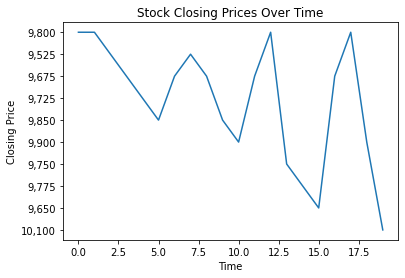

In [18]:
# exploratory data analysis
if not data.empty:
    print("Basic Statistics:")
    print(data.describe())
    
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Visualize the data
    sns.lineplot(x=data.index, y='Price', data=data)
    plt.title('Stock Closing Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.show()

In [19]:
# data cleansing
if not data.empty:
    # Handle missing values
    data.fillna(method='ffill', inplace=True)

    # Convert numeric columns with commas and shorthand to float
    def parse_numeric(value):
        if isinstance(value, str):
            if 'M' in value:
                return float(value.replace('M', '')) * 1e6
            elif 'K' in value:
                return float(value.replace('K', '')) * 1e3
            else:
                return float(value.replace(',', ''))
        return value

    for column in ['Open', 'High', 'Low', 'Price', 'Vol.']:
        if column in data.columns:
            data[column] = data[column].apply(parse_numeric)

    # Feature and target selection
    features = data[['Open', 'High', 'Low', 'Vol.']]  # Adjust based on dataset
    target = data['Price']

    # Normalize the features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

Linear Regression Performance:
Mean Squared Error: 3485.3430877131354
R-squared: 0.17384460143096048

Random Forest Performance:
Mean Squared Error: 8282.171875
R-squared: -0.9631814814814814

SVR Performance:
Mean Squared Error: 4745.61219598003
R-squared: -0.12488585386193307

Decision Tree Performance:
Mean Squared Error: 7187.5
R-squared: -0.7037037037037037

Best Model: Linear Regression


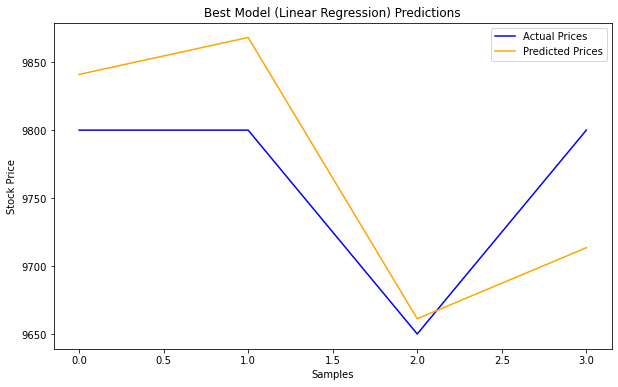

In [20]:
# model building
if not data.empty:
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)

    # Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # Support Vector Regressor
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    svr_pred = svr_model.predict(X_test)

    # Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Step 5: Evaluation
    model_performance = {}
    models = {'Linear Regression': lr_pred, 'Random Forest': rf_pred, 'SVR': svr_pred, 'Decision Tree': dt_pred}
    for name, predictions in models.items():
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        model_performance[name] = {'MSE': mse, 'R2': r2}
        print(f"{name} Performance:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}\n")

    # Identify the best model based on R-squared
    best_model_name = max(model_performance, key=lambda x: model_performance[x]['R2'])
    print(f"Best Model: {best_model_name}")

    # Predict using the best model
    if best_model_name == 'Linear Regression':
        best_model = lr_model
    elif best_model_name == 'Random Forest':
        best_model = rf_model
    elif best_model_name == 'SVR':
        best_model = svr_model
    elif best_model_name == 'Decision Tree':
        best_model = dt_model

    final_predictions = best_model.predict(X_test)

    # Plot the best model's predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Prices', color='blue')
    plt.plot(final_predictions, label='Predicted Prices', color='orange')
    plt.title(f'Best Model ({best_model_name}) Predictions')
    plt.xlabel('Samples')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()